In [10]:
#@markdown SetUp
%pip install ortools
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install openpyxl
import sys
import pandas as pd
from IPython.display import clear_output
from os import path
from ortools.linear_solver import pywraplp
if 'google.colab' in sys.modules:
    print("Trabajando en Colab")
    from google.colab import files # type: ignore
clear_output()

In [11]:
#### Declaración de funciones
def ImportBase(base_path, describe=True):
    """
    Función que lee la base de datos, revisa la existencia en la carpeta
    y despliega la información de estadistica descriptiva
    """
    if ( not path.exists(base_path)):
        print("Por favor importar al espacio de trabajo el archivo Base.xlsx")
        uploaded = files.upload()
        clear_output()
    Base = pd.read_excel(base_path)
    if describe==True:
        display("La Base de datos con la que se trabaja, a la cual se le asignó el nombre de 'Base' tiene las siguientes caracteristicas")
        display(Base.describe(include='all'))
        display("Por lo que se trabaja con los siguientes tipos de datos:")
        display(Base.dtypes)
    return Base

def get_EA(Base, EA_tags = ['COD. ESPACIO',  'ESPACIO ACADEMICO', "GRUPO", "COD. PROYECTO CURRICULAR", "PROYECTO CURRICULAR"],
            show=True):
    """
    Función que extrae de Base las materias, con la información
    correspondiente a las horas/semana y los días a la semana.
    """
    EA = Base[EA_tags].drop_duplicates()#EA = Espacios académicos

    # Adición de información correspondiente a cantidad de estudiantes por grupo !Pendiente
    # <----PENDIENTE---->

    EA_tags.append("DIA") #Se añade DIA a las etiquetas de agregación, esto para poder saber por cada día cuantas horas ('count') tiene cada espacio académico
    EA_operations = Base.groupby(by= EA_tags).count()[['HORA','ORDEN HORA']].reset_index() #reiniciar el index para poder trabajar con los datos como Dataframe completa
    EA_tags.pop() # Quitar DIA como etiqueta de agregación para poderla usar como parametro posteriormente
    EA_operations = EA_operations.groupby(by= EA_tags).agg({ 
    'HORA':'sum', #Mean o max, mean ayuda a encontrar si no todas las horas de la semana son las mismas si el valor no es entero
    'DIA': 'count'
    }) # podría revisar si es buena idea definir todas las funciones simultaneamente
    EA = EA_operations.rename( # Cambio de nombre de HORA: HORAS/DIA & DIA: DIAS/SEMANA
    columns={
        'HORA': 'HORAS/SEMANA',
        'DIA': 'DIAS/SEMANA'
        }
    ).reset_index()
    # max(), count() encuentra las horas por día sum() las horas por semana, count() encuentra los días por semana
    if show == True:
        display("Entonces, los espacios académicos con la información relacionada a HORAS/DIA Y DIAS/SEMANA es la siguiente:",EA)
    return EA

def get_DS(show=True):
    """
    Función que extrae los dias de la semana en forma de DataFrame de pandas
    """
    DS = pd.DataFrame({"DIA":["LUNES", "MARTES", "MIERCOLES", "JUEVES", "VIERNES", "SABADO", "DOMINGO"]}
                              ).reset_index(drop=True) #@param {type: "raw"} días a la semana
    if show == True:
        display(DS)
    return DS

def get_FH(h_inicial, h_final, extensiones_de_bloques, show=True):
    """
    Función que extrae todas las franjas horarias posibles 
    en un rango de tiempo determinado para extensiones de 
    bloques definidas en forma de DataFrame de Pandas.
    """
    x ={}
    f = pd.DataFrame(columns=["DURACION", "HORA INICIO", "HORA FINAL"])
    for i in extensiones_de_bloques:
        hr = 1 #horas restantes
        start = 0
        while(hr>0):
            if start==0:
                hib = h_inicial#Hora de inicio de bloque
                #print("inicial")
            else:
                hib = hib+1
                #print(hib)
            hfb = hib+i#Hora final bloque
            hr = h_final-hfb
            start = start+1
            #print(f"bloque de {i} horas: {hib}-{hfb}, {hr}")
            f = pd.concat( [f,pd.DataFrame({
                "DURACION": [i],
                "HORA INICIO": [hib],
                "HORA FINAL": [hfb]
            })
        ])   
    f = f.reset_index(drop=True)
    if show==True:
        display(f)         
    return f
def get_RestriccionesFranjasHorarias(FranjasHorarias):
    """Se define que las restricciones de este modelo cuentan que si 
    otras franjas estan en el mismo horario no pueden coexistir, 
    por lo tanto sus valores no pueden ser positivos simultaneamente"""
    f = FranjasHorarias
    f_index = f.index.values
    f.loc[f.index[1]]
    irf = pd.DataFrame(columns=["i.1","i.2"]) #indices de restriccion de franjas
    for i in f.index:
        for j in f.tail(len(f)-len(f.head(f.index[i]))).index:
            i_start = f.loc[i,"HORA INICIO"]
            i_end = f.loc[i,"HORA FINAL"]
            j_start = f.loc[j,"HORA INICIO"]
            j_end = f.loc[j,"HORA FINAL"]
            if not (i_start <=j_end and i_end <=j_start):
            #print(i," ", j, "-", i_start,"^", i_end, "--", j_start,"^", j_end)
                irf = pd.concat([irf,
                            pd.DataFrame({
                                    "i.1":[i],
                                    "i.2":[j]
                                })]
                            )
    irf = irf[irf["i.1"]!=irf["i.2"]].reset_index(drop=True)
    return irf

def get_EF(Base,EF_tags = ["COD. EDIFICIO", "EDIFICIO", "COD. SALON", "SALON", "CAPACIDAD"], show=True):
    """
    Función que extrae la información correspondiente a los espacios físicos
    disponibles en la base de datos proporcionada BASE.xlsx,
    !!importante: Rectificar que todas las salas esten mencionadas.
    """
    EF = Base[EF_tags].drop_duplicates()
    EF = pd.concat([EF,pd.DataFrame({"SALON":["VIRTUAL"]})]).reset_index(drop=True)
    if show==True:
        display(EF)
    return EF


# Asignador Automático de Salones por medio de Investigación de Operaciones
*Cristian David Monsalve Alfonso, contacto: cdmonsalvea@udistrital.edu.co <br> Rafael Nicolas Carrillo Parra, contacto:
rncarrillop@correo.udistrital.edu.co*


## Definición del problema
La presente libreta de Jupyter contiene el proyecto de asignación de horarios para la facultad de ingenieras de la Universidad Distrital.

El objetivo del proyecto es hacer uso del modelo de asignación de investigación de operación para definir la posible asignación de espacios académicos ofertados en la facultad de ingeniería, en los espacios físicos disponibles en las franjas horarias correspondientes.

Para esta tarea se requiere el entendimiento de varios aspectos base dentro del funcionamiento de la institución educativa:
* La Universidad Distrital Francisco José de Caldas actualmente oferta clases entre las 6 AM y las 10 PM, de lunes a viernes y sábados hasta las 6 PM.
* Las clases se ofertan en bloques de dos o tres horas, distribuidos en varios días de acuerdo a la asignatura.
* Actualmente se permite un máximo de 20% de clases virtuales, Se busca volver por completo a presencialidad.
* Los espacios físicos tienen una capacidad definida y están en diferentes locaciones.

Por las consideraciones anteriores se propone una solución por medio de un modelo de programación binaria cuyo modelo se desarrollará más adelante.


### Estadísticas importantes
Como base de datos principal se manejará la correspondiente a la información del sistema de gestión académica que registra (para la facultad de ingeniería) la siguiente información. 

*(importar al espacio de trabajo los archivos Base.xlsx)*

In [12]:
#@markdown ---
Base = ImportBase('Base.xlsx')

"La Base de datos con la que se trabaja, a la cual se le asignó el nombre de 'Base' tiene las siguientes caracteristicas"

,PERIODO,SEDE,EDIFICIO,SALON,ORDEN DIA,DIA,ORDEN HORA,HORA,GRUPO,COD. ESPACIO,...,COD. SALON,SALON.1,CAPACIDAD,COD. PROYECTO CURRICULAR,PROYECTO CURRICULAR,COD. EDIFICIO,EDIFICIO.1,DOCENTE,CORREO,TIPO VINCULACIÓN
count,3156,3156,3156,3156,3156.000000,3156,3156.000000,3156,3156,3.156000e+03,...,3156,3156,3156.000000,3156.000000,3156,3156,3156,1861,1861,1847
unique,1,3,3,67,NaN,7,NaN,16,94,NaN,...,79,67,NaN,NaN,17,3,3,255,255,6
top,2023-1,CALLE 40,SABIO CALDAS,AULA 203,NaN,JUEVES,NaN,9AM-10AM,007-741,NaN,...,FICC020320,AULA 203,NaN,NaN,INGENIERIA INDUSTRIAL,FICC02,SABIO CALDAS,CESAR ASDRALDO VARGAS HERNANDEZ,ceavargash@correo.udistrital.edu.co,DOCENTE DE VINCULACION ESPECIAL - HORA CATEDRA
freq,3156,2312,2312,175,NaN,619,NaN,257,208,NaN,...,88,175,NaN,NaN,659,2312,2312,22,22,763
mean,NaN,NaN,NaN,NaN,3.376743,NaN,7.650824,NaN,NaN,2.333895e+06,...,NaN,NaN,39.657795,37.151458,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.659726,NaN,4.266674,NaN,NaN,6.670606e+06,...,NaN,NaN,21.289674,63.594026,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,1.000000e+00,...,NaN,NaN,10.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2.000000,NaN,4.000000,NaN,NaN,1.300000e+01,...,NaN,NaN,24.000000,7.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,3.000000,NaN,7.000000,NaN,NaN,1.065000e+02,...,NaN,NaN,32.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,NaN,11.000000,NaN,NaN,3.420000e+02,...,NaN,NaN,57.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN


'Por lo que se trabaja con los siguientes tipos de datos:'

PERIODO                     object
SEDE                        object
EDIFICIO                    object
SALON                       object
ORDEN DIA                    int64
DIA                         object
ORDEN HORA                   int64
HORA                        object
GRUPO                       object
COD. ESPACIO                 int64
ESPACIO ACADEMICO           object
COD. SALON                  object
SALON.1                     object
CAPACIDAD                    int64
COD. PROYECTO CURRICULAR     int64
PROYECTO CURRICULAR         object
COD. EDIFICIO               object
EDIFICIO.1                  object
DOCENTE                     object
CORREO                      object
TIPO VINCULACIÓN            object
dtype: object

Las estadisticas importantes para el modelo son las siguientes:
* Espacios académicos, horas/día y días por semana que se imparte, demanda de equipos de computo
* Salones, capacidad del salon, existencia de computo, si es laboratorio, 

De estos datos es importante los referentes a los Espacios Académicos, estas son:
* Código de Proyecto Curricular que oferta el espacio académico
* Proyecto Curricular que oferta el espacio académico
* Codigo de Espacio Académico
* Espacio Académico
* Capacidad (por el momento se considera que esta es la demanda de clases, debería encontrarse una mejor forma de hacerlo, revisando la verdadera demanda de los alumnos para las respectivas clases)
* Docente - - Es necesario revisar si esta información puede llevar a restricciones
* !!Importante: definir si las materias necesitan o no computador
* !!Importante: definir las horas al día por materia (ejemplo: 2 horas por día)
* !!Importante: definir la cantidad de días a ver la materia (ejemplo: 3 días a la semana)
* !!Importante: Definir los tipos de bloques que Existen en la facultad
* !!Importante: Buscar como definir un peso para darle a la materia en donde más peso significa más valioso para conservar presencial y menor peso significa que la materia puede ser suceptible a clases virtuales.


#### Espacios académicos, horas/semana y dias/semana

In [13]:
#@markdown ---
# Lista de Espacios académicos
#@markdown Columnas que aseguran la extracción de la lista de materias
EA_tags = ['COD. ESPACIO',  'ESPACIO ACADEMICO', "GRUPO", "COD. PROYECTO CURRICULAR", "PROYECTO CURRICULAR"] #@param {type:"raw"} #tags que encuentran la lista de materias
EA = get_EA(Base, EA_tags)
#markdown: problema potencial si las horas no son iguales por cada sesión

'Entonces, los espacios académicos con la información relacionada a HORAS/DIA Y DIAS/SEMANA es la siguiente:'

,COD. ESPACIO,ESPACIO ACADEMICO,GRUPO,COD. PROYECTO CURRICULAR,PROYECTO CURRICULAR,HORAS/SEMANA,DIAS/SEMANA
0,1,CALCULO DIFERENCIAL,005-1,5,INGENIERIA ELECTRONICA,2,1
1,1,CALCULO DIFERENCIAL,005-11,5,INGENIERIA ELECTRONICA,6,3
2,1,CALCULO DIFERENCIAL,005-13,5,INGENIERIA ELECTRONICA,4,2
3,1,CALCULO DIFERENCIAL,005-15,5,INGENIERIA ELECTRONICA,4,2
4,1,CALCULO DIFERENCIAL,005-3,5,INGENIERIA ELECTRONICA,2,1
...,...,...,...,...,...,...,...
951,39502007,SERVICIOS GEOGRAFICOS WEB,395-1,395,MAE. EN CIENCIAS DE LA INF. Y LAS COMUNICACION...,4,1
952,39503002,SISTEMAS DE POSICIONAMIENTO GEODESICO,395-1,395,MAE. EN CIENCIAS DE LA INF. Y LAS COMUNICACION...,4,1
953,49501001,INGENIERIA DE SOFTWARE I,495-1,495,MAE. EN CIENCIAS DE LA INF. Y LAS COMUNICACION...,4,1
954,49502001,INGENIERIA DE SOFTWARE II,495-1,495,MAE. EN CIENCIAS DE LA INF. Y LAS COMUNICACION...,4,2


#### Espacios físicos, capacidad

La información correspondiente a los espacios físicos está proporcionada en la misma base de datos, aunque falta confirmar si en esta se aprovecha la totalidad de los espacios físicos.


In [14]:
#@markdown ---

EF_tags = ["COD. EDIFICIO", "EDIFICIO", "COD. SALON", "SALON", "CAPACIDAD"] #@param {type: "raw"} #Ingreso de los parametros que filtran la información de espacios fisicos "salones" en la base de datos
#@markdown Revisar si quitando y poniendo capacidad son la misma cantidad de salones
EF = get_EF(Base,EF_tags)


,COD. EDIFICIO,EDIFICIO,COD. SALON,SALON,CAPACIDAD
0,FICC02,SABIO CALDAS,FICC02S208,AUDITORIO,160.0
1,FICC02,SABIO CALDAS,FICC020214,AULA 201,51.0
2,FICC02,SABIO CALDAS,FICC020213,AULA 202,64.0
3,FICC02,SABIO CALDAS,FICC020212,AULA 203,57.0
4,FICC02,SABIO CALDAS,FICC020206,AULA 204,70.0
...,...,...,...,...,...
75,FITE05,CALLE 42,FITE050214,LABORATORIO 202,18.0
76,FITE05,CALLE 42,FITE050115,SALA ESPECIALIZADA 01,24.0
77,FITE05,CALLE 42,FITE050120,SALA ESPECIALIZADA 02,18.0
78,FITE05,CALLE 42,FITE050111,SALA SISTEMAS,22.0


#### Tiempo
##### Días
la universidad tiene la capacidad de operar los 7 días de la semana, sin embargo es más deseable que unas clases se tengan en horarios más accesibles, como lo son entre semana en horarios más cercanos a medio día.

##### Horas

###### opción 1: trabajar las horas como franjas horarias
es un modelo más estructurado y ahorra esfuerzos en terminos de restricciones para evitar que los bloques del modelo sean separados, para esta la dimensión del tiempo debe ser f: bloques estructurados de 2,3,4,6 horas dispersos en todo el día para todas las combinaciones posibles de los horarios en los que estos pueden estar, solo debe crearse una restricción que evite que otra materia esté el mismo día en el mismo lugar
###### opción 2: trabajar las horas como numeros enteros dentro de un rango
La universidad ofrece clases en un rango de horarios, para esta opción las franjas horarias tendrán que ser definidas entendiendo que hay limites para la asignación, en este caso la dimansión correspondiente al tiempo es t: que es un espacio de dos elementos (1. hora de inicio, 2. hora de finalización) estos son numeros enteros dentro del rango de las horas de la universidad en donde
hora de inicio es siempre menor a la hora de finalización h_inicio < h_final
además se debe generar restricciones para evitar que los puntos entre inicio y final de los espacios sean ocupados, 

para esta opción la suma de las horas ($\sum_{días} X_{h_{final}}-X_{h_{inicial}} = horas/semana$) para cada día por materia en cada espacio.
adicionalmente para cada ??? $X_{h_{final}} < X_{h_{final}}\lor X_{h_{inicial}} > X_{h_{inicial}}$

In [15]:
#@markdown Días a la semana en los que se puede dictar espacios académicos
DS = get_DS()

,DIA
0,LUNES
1,MARTES
2,MIERCOLES
3,JUEVES
4,VIERNES
5,SABADO
6,DOMINGO


In [16]:
#@markdown Ingrese las horas de apertura y cierre de la universidad



h_inicial = 6 #@param {type: "integer"}
h_final = 22 #@param {type: "integer"}
extensiones_de_bloques = [2,3]

FH = get_FH(h_inicial, h_final, extensiones_de_bloques,)
##Restricciones de las franjas
franjas_restricciones = get_RestriccionesFranjasHorarias(FranjasHorarias=FH)

,DURACION,HORA INICIO,HORA FINAL
0,2,6,8
1,2,7,9
2,2,8,10
3,2,9,11
4,2,10,12
5,2,11,13
6,2,12,14
7,2,13,15
8,2,14,16
9,2,15,17


## Definición del modelo de programación lineal

### *Índices*

$i \in I$ : Tipo de asignatura : $I$ = \{ 1 = Calculo diferencial grupo: xxxx, 2 = Calculo diferencial grupo: yyyyy, 3 = Calculo diferencial grupo: zzz, ..., n\}

$j \in J$ : Día : $J$ = \{ 1 = lunes, 2 = martes, 3 = miércoles, ..., 6 = Sábado\}

$k \in K$ : Salón: $L$ = \{ 1 = Auditorio, 2 = Salón 201, .... , n = Sala de informática 705\}

$l \in L$ : Franja: $M$ = \{ 1 = 6 a 8 AM, 2 = 7 a 9 AM, .... , 25 = 7 a 10 PM\}



---------------------------------------------------------------------

### Parametros:

$w_m$: peso asignado a la franja m

$c_j$: capacidad del salón j

$t_i$: Número de estudiantes en la clase i

$v_j$: Matriz de 1 y 0 que indica si el salón j tiene sala de cómputo o no

---------------------------------------------------------------------


### *Variables*

$x_{ijkl} $: ASignación de la materia i en el salón j el día k en la franja l (Binaria)


### Función Objetivo
$$Max  F =  \sum_{i=1} \sum_{j=1} \sum_{k=1} \sum_{l=1}    X_{i,j,k,l,m}*w_{m}$$

### *Restricciones*

<br>

1. Capacidad de salones.   
$$\sum_{k=1} \sum_{l=1}\ t_{i}*x_{ijkl} \le c_{j} \space\space\space \forall_{i} \forall_{j}  $$


2. Asignación de un único salón por materia.  
$$ \sum_{i=1}\ x_{ijkl} = 1 \space\space\space \forall_{j} \forall_{k} \forall_{l} $$


3. Asignación a sala de cómputo según se necesite. (Para todo 200<i<350 y Para todo 200<j<350)
$$ \sum_{i=1}\ x_{ijkl} = v_{j} \space\space\space \forall_{j} \forall_{k} \forall_{l} $$

4. No asignar la misma clase dos veces en el mismo día
$$ \sum_{j=1}\sum_{l=1} x_{ijkl} + x_{i+1jkl} = 1 \space\space\space \forall_{k} $$

5. Máximo 20% de virtualidad (Puede causar que hayan más carreras con virtualidad que otras), salón 77 es el virtual.
$$ \sum_{i=1}\sum_{j=1}\sum_{l=1} x_{ijk77} = 0,2*976 \space\space\space$$

6. No cruzar los salones en las franjas propuestas.
2 horas par

para 1
$$ \sum_{i=1} X_{i,j,k,1} + \sum_{i=1} X_{i,j,k,2} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,1} + X_{i,j,k,16} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,1} + \sum_{i=1} X_{i,j,k,21} = 1 \space\space\space \forall_{j} \forall_{k}$$
para 3
$$ \sum_{i=1} X_{i,j,k,3} + \sum_{i=1} X_{i,j,k,2} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,3} + \sum_{i=1} X_{i,j,k,4} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,3} + \sum_{i=1} X_{i,j,k,16} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,3} + \sum_{i=1} X_{i,j,k,17} = 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,3} + \sum_{i=1} X_{i,j,k,21}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 5
$$ \sum_{i=1} X_{i,j,k,5} + \sum_{i=1} X_{i,j,k,4}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,5} + \sum_{i=1} X_{i,j,k,6}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,5} + \sum_{i=1} X_{i,j,k,17}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,5} + \sum_{i=1} X_{i,j,k,22}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 7
$$ \sum_{i=1} X_{i,j,k,7} + \sum_{i=1} X_{i,j,k,l,6}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,7} + \sum_{i=1} X_{i,j,k,8}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,7} + \sum_{i=1} X_{i,j,k,18}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,7} + \sum_{i=1} X_{i,j,k,22}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,7} + \sum_{i=1} X_{i,j,k,23}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 9
$$ \sum_{i=1} X_{i,j,k,9} + \sum_{i=1} X_{i,j,k,8}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,9} + \sum_{i=1} X_{i,j,k,10}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,9} + \sum_{i=1} X_{i,j,k,18}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,9} + \sum_{i=1} X_{i,j,k,19}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,9} + \sum_{i=1} X_{i,j,k,23}=1 \space\space\space \forall_{j} \forall_{k}$$
para 11
$$ \sum_{i=1}X_{i,j,k,11} +\sum_{i=1} X_{i,j,k,10}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1} X_{i,j,k,11} +\sum_{i=1} X_{i,j,k,12}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,11} +\sum_{i=1} X_{i,j,k,19}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,11} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 13
$$ \sum_{i=1}X_{i,j,k,13} +\sum_{i=1} X_{i,j,k,12}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,13} +\sum_{i=1} X_{i,j,k,14}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,13} +\sum_{i=1}X_{i,j,k,20}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,13} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,13} +\sum_{i=1}X_{i,j,k,25}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 15
$$ \sum_{i=1}X_{i,j,k,15} +\sum_{i=1} X_{i,j,k,14}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,15} +\sum_{i=1} X_{i,j,k,20}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,15} +\sum_{i=1} X_{i,j,k,25}= 1 \space\space\space \forall_{j} \forall_{k}$$

2 horas impar

para 2
$$ \sum_{i=1}X_{i,j,k,2} +\sum_{i=1} X_{i,j,k,16}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,2} +\sum_{i=1} X_{i,j,k,21}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 4
$$ \sum_{i=1}X_{i,j,k,4} +\sum_{i=1} X_{i,j,k,17}= 1\space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,4} +\sum_{i=1} X_{i,j,k,21}= 1\space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,4} +\sum_{i=1} X_{i,j,k,22}= 1\space\space\space \forall_{j} \forall_{k}$$
para 6
$$ \sum_{i=1}X_{i,j,k,6} +\sum_{i=1} X_{i,j,k,17}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,6} +\sum_{i=1} X_{i,j,k,18}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,6} +\sum_{i=1} X_{i,j,k,22}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 8
$$ \sum_{i=1}X_{i,j,k,8} +\sum_{i=1} X_{i,j,k,18}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,8} +\sum_{i=1} X_{i,j,k,23}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 10
$$ \sum_{i=1}X_{i,j,k,10} +\sum_{i=1} X_{i,j,k,19= 1} \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,10} +\sum_{i=1} X_{i,j,k,23}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,10} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 12
$$ \sum_{i=1}X_{i,j,k,12} +\sum_{i=1} X_{i,j,k,19}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,12} +\sum_{i=1} X_{i,j,k,20}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,12} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 14
$$ \sum_{i=1}X_{i,j,k,14} +\sum_{i=1} X_{i,j,k,20}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,14} +\sum_{i=1} X_{i,j,k,25}= 1 \space\space\space \forall_{j} \forall_{k}$$

3 horas par

para 16
$$ \sum_{i=1}X_{i,j,k,16} + \sum_{i=1} X_{i,j,k,21}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 17
$$ \sum_{i=1}X_{i,j,k,17} +\sum_{i=1} X_{i,j,k,21}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,17} +\sum_{i=1} X_{i,j,k,22}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 18
$$ \sum_{i=1}X_{i,j,k,18} +\sum_{i=1} X_{i,j,k,22}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,18} +\sum_{i=1} X_{i,j,k,23}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 19
$$ \sum_{i=1}X_{i,j,k,19} +\sum_{i=1} X_{i,j,k,23}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,19} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
para 20
$$ \sum_{i=1}X_{i,j,k,20} +\sum_{i=1} X_{i,j,k,24}= 1 \space\space\space \forall_{j} \forall_{k}$$
$$ \sum_{i=1}X_{i,j,k,20} +\sum_{i=1} X_{i,j,k,25}= 1 \space\space\space \forall_{j} \forall_{k}$$





### Restricciones

Restricciones:

No puede tener más de una materia al tiempo en el mismo lugar

para todas i, j, m,  1,1,1 =0

Restricciones de capacidad

Restricciones de clases con computadores

Restricciones de clases virtuales

## pendiente pensar que hacer con las franjas

$X_{i,j,k,l,m} \in (0,1)$



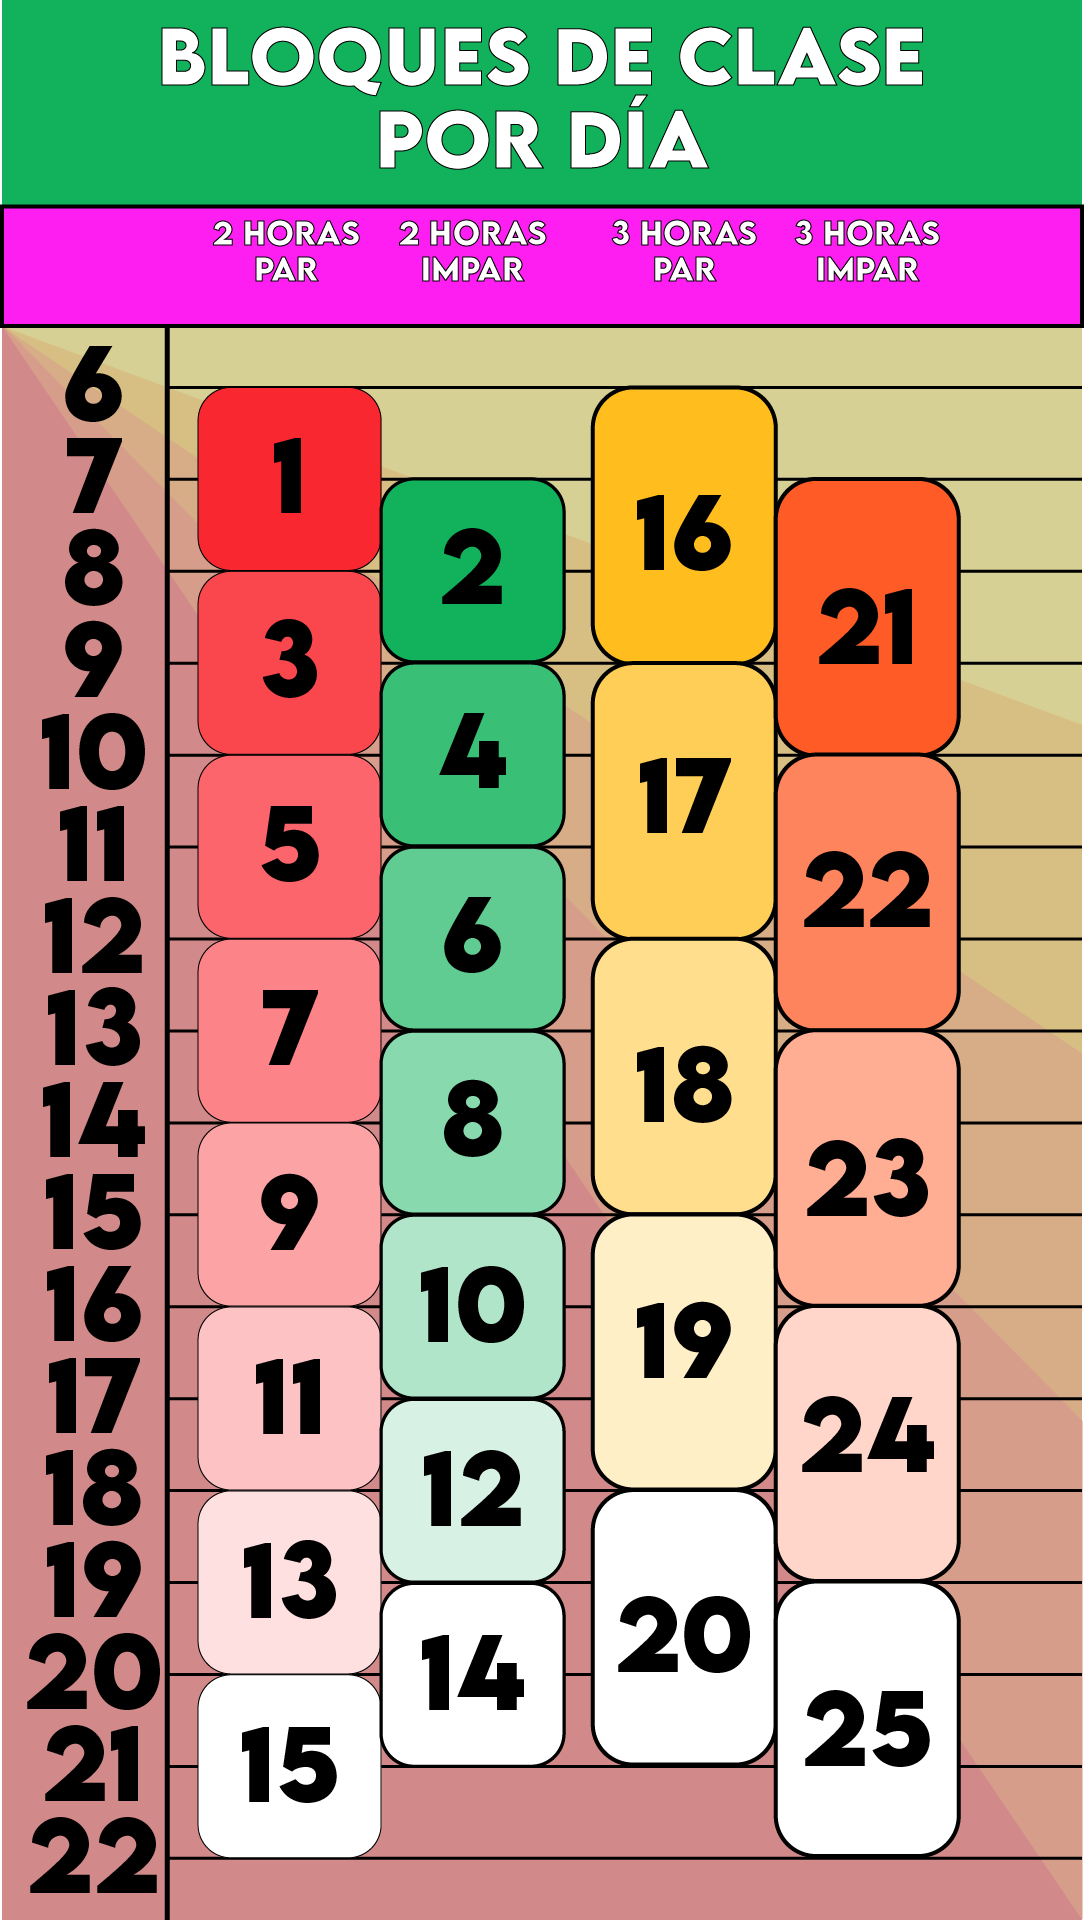

Que implica que **Restricción de al mismo tiempo**

2 horas par

para 1
$$ X_{i,j,k,l,1} \neq X_{i,j,k,l,2}$$
$$ X_{i,j,k,l,1} \neq X_{i,j,k,l,16}$$
$$ X_{i,j,k,l,1} \neq X_{i,j,k,l,21}$$
para 3
$$ X_{i,j,k,l,3} \neq X_{i,j,k,l,2}$$
$$ X_{i,j,k,l,3} \neq X_{i,j,k,l,4}$$
$$ X_{i,j,k,l,3} \neq X_{i,j,k,l,16}$$
$$ X_{i,j,k,l,3} \neq X_{i,j,k,l,17}$$
$$ X_{i,j,k,l,3} \neq X_{i,j,k,l,21}$$
para 5
$$ X_{i,j,k,l,5} \neq X_{i,j,k,l,4}$$
$$ X_{i,j,k,l,5} \neq X_{i,j,k,l,6}$$
$$ X_{i,j,k,l,5} \neq X_{i,j,k,l,17}$$
$$ X_{i,j,k,l,5} \neq X_{i,j,k,l,22}$$
para 7
$$ X_{i,j,k,l,7} \neq X_{i,j,k,l,6}$$
$$ X_{i,j,k,l,7} \neq X_{i,j,k,l,8}$$
$$ X_{i,j,k,l,7} \neq X_{i,j,k,l,18}$$
$$ X_{i,j,k,l,7} \neq X_{i,j,k,l,22}$$
$$ X_{i,j,k,l,7} \neq X_{i,j,k,l,23}$$
para 9
$$ X_{i,j,k,l,9} \neq X_{i,j,k,l,8}$$
$$ X_{i,j,k,l,9} \neq X_{i,j,k,l,10}$$
$$ X_{i,j,k,l,9} \neq X_{i,j,k,l,18}$$
$$ X_{i,j,k,l,9} \neq X_{i,j,k,l,19}$$
$$ X_{i,j,k,l,9} \neq X_{i,j,k,l,23}$$
para 11
$$ X_{i,j,k,l,11} \neq X_{i,j,k,l,10}$$
$$ X_{i,j,k,l,11} \neq X_{i,j,k,l,12}$$
$$ X_{i,j,k,l,11} \neq X_{i,j,k,l,19}$$
$$ X_{i,j,k,l,11} \neq X_{i,j,k,l,24}$$
para 13
$$ X_{i,j,k,l,13} \neq X_{i,j,k,l,12}$$
$$ X_{i,j,k,l,13} \neq X_{i,j,k,l,14}$$
$$ X_{i,j,k,l,13} \neq X_{i,j,k,l,20}$$
$$ X_{i,j,k,l,13} \neq X_{i,j,k,l,24}$$
$$ X_{i,j,k,l,13} \neq X_{i,j,k,l,25}$$
para 15
$$ X_{i,j,k,l,15} \neq X_{i,j,k,l,14}$$
$$ X_{i,j,k,l,15} \neq X_{i,j,k,l,20}$$
$$ X_{i,j,k,l,15} \neq X_{i,j,k,l,25}$$

2 horas impar

para 2
$$ X_{i,j,k,l,2} \neq X_{i,j,k,l,16}$$
$$ X_{i,j,k,l,2} \neq X_{i,j,k,l,21}$$
para 4
$$ X_{i,j,k,l,4} \neq X_{i,j,k,l,17}$$
$$ X_{i,j,k,l,4} \neq X_{i,j,k,l,21}$$
$$ X_{i,j,k,l,4} \neq X_{i,j,k,l,22}$$
para 6
$$ X_{i,j,k,l,6} \neq X_{i,j,k,l,17}$$
$$ X_{i,j,k,l,6} \neq X_{i,j,k,l,18}$$
$$ X_{i,j,k,l,6} \neq X_{i,j,k,l,22}$$
para 8
$$ X_{i,j,k,l,8} \neq X_{i,j,k,l,18}$$
$$ X_{i,j,k,l,8} \neq X_{i,j,k,l,23}$$
para 10
$$ X_{i,j,k,l,10} \neq X_{i,j,k,l,19}$$
$$ X_{i,j,k,l,10} \neq X_{i,j,k,l,23}$$
$$ X_{i,j,k,l,10} \neq X_{i,j,k,l,24}$$
para 12
$$ X_{i,j,k,l,12} \neq X_{i,j,k,l,19}$$
$$ X_{i,j,k,l,12} \neq X_{i,j,k,l,20}$$
$$ X_{i,j,k,l,12} \neq X_{i,j,k,l,24}$$
para 14
$$ X_{i,j,k,l,14} \neq X_{i,j,k,l,20}$$
$$ X_{i,j,k,l,14} \neq X_{i,j,k,l,25}$$

3 horas par

para 16
$$ X_{i,j,k,l,16} \neq X_{i,j,k,l,21}$$
para 17
$$ X_{i,j,k,l,17} \neq X_{i,j,k,l,21}$$
$$ X_{i,j,k,l,17} \neq X_{i,j,k,l,22}$$
para 18
$$ X_{i,j,k,l,18} \neq X_{i,j,k,l,22}$$
$$ X_{i,j,k,l,18} \neq X_{i,j,k,l,23}$$
para 19
$$ X_{i,j,k,l,19} \neq X_{i,j,k,l,23}$$
$$ X_{i,j,k,l,19} \neq X_{i,j,k,l,24}$$
para 20
$$ X_{i,j,k,l,20} \neq X_{i,j,k,l,24}$$
$$ X_{i,j,k,l,20} \neq X_{i,j,k,l,25}$$

!! Importante: falta definir para que otras dimensiones son validas las restricciones, por el momento se cree que para cada salón (l) y cada sesión (j), cabe evaluar si es valioso en (i) y (k)



## Programación del modelo en Python

In [25]:
Base = ImportBase('Base.xlsx',describe=False)
EA = get_EA(Base, show=False)
EF = get_EF(Base, show=False)
DS = get_DS(show=False)
FH = get_FH(h_inicial, h_final,[2,3,4,6,1],show=False)

porcentaje_usado = .3
EA = EA.sample(10)
EF = EF.sample(2)
DS = DS.sample(3)
FH = FH.sample(10)
print(
"\n# Espacios académicos \n",
EA.index.values,
"\n# Espacios físicos \n",
EF.index.values,
"\n# Dias de la Semana \n",
DS.index.values,
"\n# Franjas Horarias \n",
FH.index.values,
"\n# Cantidad de Variables \n",
len(EA.index.values)*len(EF.index.values)*len(DS.index.values)*len(FH.index.values)
)


# Espacios académicos 
 [606 354 113 837 365  49 370 359 396 111] 
# Espacios físicos 
 [72 24] 
# Dias de la Semana 
 [2 6 1] 
# Franjas Horarias 
 [14 66 16 30 36 32 24 41 43  9] 
# Cantidad de Variables 
 600


In [26]:
#Creación del modelo en cp_model
def Ejecutar_Solver():
    solver = pywraplp.Solver.CreateSolver("CP_SAT")
    """
    i: Tipo de Espacio academico,
    k: Espacio Fisico,
    j: Dia,
    l: Franja
    """
    X = {}
    F_ = []
    for i in EA.index.values:
        for k in EF.index.values:
            for j in DS.index.values:
                for l in FH.index.values:
                    X[i,k,j,l] = solver.IntVar(0,1,"%i-%i-%i-%i" %(i,k,j,l))
                    F_.append(X[i,k,j,l])             
    #Sujeto a:
        """Restricciones"""
    #### CADA MATERIA SOLO SE PUEDE VER EN UN SALON CADA DÍA
    #for j in DS.index.values:
    #    for i in EA.index.values:
    #        solver.Add(solver.Sum(X[i,k,j,l] for k in EF.index.values for l in FH.index.values)==1)
        
    #### ASIGNE N VECES POR SEMANA POR MATERIA
    for i in EA.index.values:
        solver.Add(solver.Sum(X[i,k,j,l] for j in DS.index.values for k in EF.index.values for l in FH.index.values) == EA['DIAS/SEMANA'].loc[i])
    for j in DS.index.values: 
        solver.Add(solver.Sum(X[i,k,j,l]))
#    for k in EF.index.values:
#        for j in DS.index.values:
#            solver.Add(solver.Sum(X[i,k,j,l] for l in FH) <= h_final-h_inicial)

    solver.Maximize(solver.Sum(F_))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        print("F = ", solver.Objective().Value())
        for i in EA.index.values:
            for k in EF.index.values:
                for j in DS.index.values:
                    for l in FH.index.values:
                        if (X[i,k,j,l].solution_value() == 1):
                            Espacio_Academico = EA.loc[i,"ESPACIO ACADEMICO"]+"-"+EA.loc[i,"GRUPO"]
                            Espacio_Fisico = str(EF.loc[k,"EDIFICIO"]) + "-" + str(EF.loc[k,"SALON"])
                            Dia = DS.loc[j,"DIA"]
                            Franja_Horaria = str(FH.loc[l,"HORA INICIO"])+"-"+str(FH.loc[l,"HORA FINAL"])
                            print(Espacio_Academico, "__", Espacio_Fisico, "__", Dia, "__", Franja_Horaria)
                    #else:
                        #print("OSI")
    else:
        print('The problem does not have an optimal solution.')

Ejecutar_Solver()

F =  14.0
ELECTRONICA I-007-741 __ SABIO CALDAS-AULA 407 __ MARTES __ 18-22
ELECTRONICA I-007-741 __ SABIO CALDAS-AULA 407 __ MARTES __ 7-13
ELECTRONICA I-007-741 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
CATEDRA DE CONTEXTO-015-21 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
CATEDRA FRANCISCO JOSE DE CALDAS-020-82 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
SEMINARIO TRABAJO DE GRADO-005-1 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
HOMBRE SOCIEDAD Y ECOLOGIA-007-741 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
PROGRAMACION BASICA-015-29 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
ELECTRONICA DE POTENCIA-005-1 __ SABIO CALDAS-AULA 407 __ MARTES __ 7-13
ELECTRONICA DE POTENCIA-005-1 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
COMUNICACIONES DIGITALES-005-3 __ SABIO CALDAS-AULA 407 __ MARTES __ 7-13
COMUNICACIONES DIGITALES-005-3 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
INGENIERIA ECONOMICA-005-1 __ SABIO CALDAS-AULA 407 __ MARTES __ 15-17
CATEDRA FRANCISCO JOSE DE CALDAS-015-29 __ S

In [ ]:
def get_solution(X,solver,status):
    if status == pywraplp.Solver.OPTIMAL:
        sol = pd.DataFrame(columns=["ESPACIO ACADÉMICO", "ESPACIO FÍSICO", "DÍA", ""])
        print("F = ", solver.Objective().Value())
        for i in EA.index.values:
            for k in EF.index.values:
                for j in DS.index.values:
                    for l in FH.index.values:
                        Espacio_Academico = EA.loc[i,"ESPACIO ACADEMICO"]+"-"+EA.loc[i,"GRUPO"]
                        Espacio_Fisico = str(EF.loc[k,"EDIFICIO"]) + "-" + str(EF.loc[k,"SALON"])
                        Dia = DS.loc[j,"DIA"]
                        Franja_Horaria = str(FH.loc[l,"HORA INICIO"])+"-"+str(FH.loc[l,"HORA FINAL"])
                        print(Espacio_Academico, "__", Espacio_Fisico, "__", Dia, "__", Franja_Horaria)
    else:
        print('The problem does not have an optimal solution.')